In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
# !pip install --upgrade torch torchvision

## Data

In [100]:
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

In [101]:
class Config:
    base_input_path = "/workspace/kaggle-notebooks/"
    batch_size = 16
    num_workers = 2
    n_epochs = 10
    lr = 1e-3
    
    def __init__(self):
        pass
    
config = Config()

def convert_num2label(num: int) -> str:
    return {
        "0": "Cassava Bacterial Blight (CBB)",
        "1": "Cassava Brown Streak Disease (CBSD)",
        "2": "Cassava Green Mottle (CGM)",
        "3": "Cassava Mosaic Disease (CMD)",
        "4": "Healthy",
    }[num]


def class2dict(f) -> Dict:
    ans = dict()
    for name in dir(f):
        if name.startswith("__"):
            continue
        if not _is_primitive(getattr(f, name)):
            ans[name] = class2dict(getattr(f, name))
        else:
            ans[name] = getattr(f, name)
    return ans


def _is_primitive(value) -> bool:
    primitive = (int, str, bool, float, List, Dict)
    return type(value) in primitive

<AxesSubplot:>

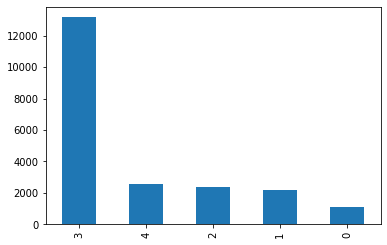

In [102]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [103]:
class CassavaDataset(Dataset):
    def __init__(self, annotation_path: str, img_dir_path: str, img_transforms: transforms.Compose):
        self.annotation_path = annotation_path
        self.annotation_data = pd.read_csv(annotation_path)
        self.img_dir_path = img_dir_path
        self.img_transforms = img_transforms
        
    def __len__(self) -> int:
        return len(self.annotation_data)
    
    def __getitem__(self, index: int):
        data = self.annotation_data.iloc[index, :]
        image_id = data["image_id"]
        label = data["label"]        
        image_path = os.path.join(self.img_dir_path, image_id)        
        img = Image.open(image_path).convert("RGB")
        if self.img_transforms:
            img = self.img_transforms(img)
        label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
        label = torch.squeeze(label, dim=0).float()
        return img, label

In [104]:
datasets = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
)

In [105]:
dataloader = DataLoader(
    datasets,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers
)

## Network

In [106]:
from torchvision.models import resnet18


class CassavaNetwork(nn.Module):
    def __init__(self, input_dim: int = 3, output_dim: int = 5):
        super().__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(
            input_dim,
            64,
            kernel_size=(7, 7),
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )
        self.base_model.fc = nn.Linear(in_features=512, out_features=output_dim, bias=True)
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.base_model(img)

## Trainer

In [107]:
import numpy as np
from typing import Optional
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch

import sys
import os


class TrainerOutput:
    loss: float

    def __init__(self, loss: float):
        self.loss = loss

    @property
    def score(self) -> float:
        return self.loss


class Trainer:
    model: nn.Module
    optimizer: optim.Optimizer
    lr_scheduler: optim.lr_scheduler._LRScheduler
    loss_function: nn.CrossEntropyLoss
    dataloader: DataLoader
    scaler: Optional[GradScaler]

    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        lr_scheduler: optim.lr_scheduler._LRScheduler,
        loss_function: nn.CrossEntropyLoss,
        dataloader: DataLoader,
        scaler: Optional[GradScaler] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.scaler = scaler

    def advance(self, verbose: bool = False) -> TrainerOutput:
        scaler = None
        if self.scaler:
            scaler = self.scaler
        self.model = self.model.train()
        GPU_DEVICE = torch.device("cuda")
        epoch_loss = 0
        with autocast(enabled=True):
            with torch.enable_grad():
                for batch in tqdm(self.dataloader):
                    if len(batch) == 3:
                        imgs, _, labels = batch
                    elif len(batch) == 2:
                        imgs, labels = batch
                    else:
                        continue
                    self.optimizer.zero_grad()
                    imgs = imgs.to(GPU_DEVICE)
                    labels = labels.to(GPU_DEVICE)
                    out: torch.Tensor = self.model(imgs)
                    out = out.float()
                    if verbose:
                        print("out-shape", out.shape)
                        print("out", out)                        
                    if verbose:
                        print("labels", labels)
                    loss = self.loss_function(out, labels)
                    if verbose:
                        print("loss", loss)
                    if scaler is not None:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    epoch_loss += loss.item()
                    if scaler is not None:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()
                self.lr_scheduler.step()
        loss = epoch_loss / (len(self.dataloader))
        return TrainerOutput(loss=loss)

## Classifier

In [108]:
from typing import Callable, Dict, List, Tuple, Union, Optional
from typing_extensions import Self
import numpy as np
from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import sys
import os


class ClassifierOutput:
    move_to_full_nn_img_ids: List[str]
    count: int
    recall: float
    precision: float
    f_value: float
    acc: float
    loss: float

    def __init__(
        self,
        count: int,
        recall: float,
        precision: float,
        acc: float,
        loss: float,
        move_to_full_nn_img_ids=[],
    ):
        self.count = count
        self.recall = recall
        self.precision = precision
        if recall + precision == 0:
            self.f_value = 0
        else:
            self.f_value = (2 * recall * precision) / (recall + precision)
        self.acc = acc
        self.loss = loss
        self.move_to_full_nn_img_ids = move_to_full_nn_img_ids

    @property
    def score(self) -> float:
        return self.acc


class ClassifierTrainInput:
    def __init__(self):
        pass

class ClassifierTestInput:
    def __init__(self):
        pass

class Classifier:

    model: nn.Module
    activate_function: nn.Softmax
    loss_function: Optional[nn.CrossEntropyLoss]
    c_high: float
    c_low: float
    dataloader: DataLoader
    phase: str
    phase_input: Union[ClassifierTrainInput, ClassifierTestInput]
    on_classify: Optional[Callable]

    def __init__(
        self,
        model: nn.Module,
        activate_function: nn.Softmax,
        dataloader: DataLoader,
        phase: str,
        phase_input: Union[ClassifierTrainInput, ClassifierTestInput],
        loss_function: Optional[nn.CrossEntropyLoss] = None,
        on_classify: Optional[Callable] = None,
    ):
        self.model = model
        self.activate_function = activate_function
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.phase = phase
        self.phase_input = phase_input
        self.on_classify = on_classify

    def infer(
        self, verbose: bool = False, handle_all: bool = False
    ) -> ClassifierOutput:
        net = self.model
        loader = self.dataloader
        loss_function = self.loss_function
        count = 0
        recall = 0
        precision = 0
        correct = 0
        TP = 0
        FP = 0
        FN = 0
        GPU_DEVICE = torch.device("cuda")
        called = False
        net = net.eval()
        epoch_loss = 0
        with torch.no_grad():
            for batch in tqdm(loader):
                if len(batch) == 3:
                    imgs, _, labels = batch
                elif len(batch) == 2:
                    imgs, labels = batch
                else:
                    continue
                imgs = imgs.to(GPU_DEVICE)
                labels = labels.to(GPU_DEVICE)                
                outputs = net(imgs)
                if loss_function:
                    loss = loss_function(outputs, labels)
                    epoch_loss += loss.item()
                outputs = self.activate_function(outputs)
                if verbose:
                    print("output", outputs[:10])
                _, predicted_indexes = torch.max(dim=1, input=outputs)
                if verbose:
                    print(f"{self.phase}_predicted_indexes", predicted_indexes)
                    print(f"{self.phase}_labels", labels)
                if not called and self.on_classify is not None:
                    if not handle_all:
                        called = True
                    self.on_classify(imgs, predicted_indexes)
                labels = torch.tensor(list(map(lambda nums: (nums==1).nonzero().item(), labels))).to(GPU_DEVICE)
                count += labels.shape[0]                                
                correct += int(torch.where(predicted_indexes == labels, 1.0, 0.0).sum())            
            acc = correct / count
            epoch_loss = epoch_loss / (len(loader))
            ret = ClassifierOutput(
                count=count,
                recall=recall,
                precision=precision,
                acc=acc,
                loss=epoch_loss,
            )
            return ret

## Run

<AxesSubplot:>

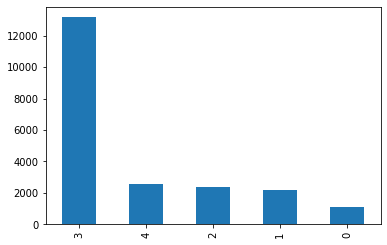

In [109]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [110]:
test_img_dir_path = os.path.join(config.base_input_path, "test_images")

In [111]:
train_datasets = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
)

In [112]:
train_dataloader = DataLoader(
    train_datasets,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers
)

In [113]:
import torch.optim as optim

model = CassavaNetwork()
model = model.to(torch.device("cuda"))
model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
loss_function = nn.CrossEntropyLoss()

activate_function = nn.Softmax(dim=1)

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    loss_function,
    dataloader,
)
classifier = Classifier(
    model,
    activate_function,
    dataloader,
    phase="train",
    phase_input=ClassifierTrainInput(),
)

for epoch in tqdm(range(config.n_epochs)):
    epoch += 1
    train_out = trainer.advance()
    print(f"epoch: {epoch}, train loss: {train_out.loss}")
    infer_out = classifier.infer()
    print(f"epoch: {epoch}, train acc: {infer_out.acc}")

100%|██████████| 1338/1338 [02:34<00:00,  8.63it/s]


epoch: 1, train loss: 1.0823012769266807


 10%|█         | 1/10 [05:04<45:36, 304.09s/it]

epoch: 1, train acc: 0.5665747534701127


100%|██████████| 1338/1338 [02:28<00:00,  9.03it/s]


epoch: 2, train loss: 0.9114384538701475


 20%|██        | 2/10 [09:57<39:42, 297.79s/it]

epoch: 2, train acc: 0.6831331495069403


100%|██████████| 1338/1338 [02:30<00:00,  8.92it/s]


epoch: 3, train loss: 0.798884146461216


 30%|███       | 3/10 [14:55<34:46, 298.00s/it]

epoch: 3, train acc: 0.7006122353600972


100%|██████████| 1338/1338 [02:25<00:00,  9.20it/s]


epoch: 4, train loss: 0.7149381984932897


 40%|████      | 4/10 [19:48<29:34, 295.81s/it]

epoch: 4, train acc: 0.6361639482170398


100%|██████████| 1338/1338 [02:27<00:00,  9.10it/s]


epoch: 5, train loss: 0.6687419079633928


 50%|█████     | 5/10 [24:47<24:44, 296.93s/it]

epoch: 5, train acc: 0.38402579800906667


100%|██████████| 1338/1338 [02:25<00:00,  9.21it/s]


epoch: 6, train loss: 0.6338423056686673


 60%|██████    | 6/10 [29:37<19:38, 294.55s/it]

epoch: 6, train acc: 0.3700051409076039


100%|██████████| 1338/1338 [02:25<00:00,  9.20it/s]


epoch: 7, train loss: 0.6119118006217819


 70%|███████   | 7/10 [34:32<14:44, 294.87s/it]

epoch: 7, train acc: 0.20596345282048886


100%|██████████| 1338/1338 [02:27<00:00,  9.06it/s]


epoch: 8, train loss: 0.606606777729564


 80%|████████  | 8/10 [39:27<09:49, 294.74s/it]

epoch: 8, train acc: 0.41571248305837266


100%|██████████| 1338/1338 [02:25<00:00,  9.21it/s]


epoch: 9, train loss: 0.5823293595681989


 90%|█████████ | 9/10 [44:22<04:55, 295.00s/it]

epoch: 9, train acc: 0.12127868392765341


100%|██████████| 1338/1338 [02:28<00:00,  9.04it/s]


epoch: 10, train loss: 0.5761868270289471


100%|██████████| 10/10 [49:16<00:00, 295.63s/it]

epoch: 10, train acc: 0.3465439080244894
